In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.utils.multiclass import unique_labels
alpha=0.3#number of percetage poisoning backdoors
delta = 65
import matplotlib.pyplot as plt
import numpy as np
batch_size = 64
num_classes = 10
epochs =7
sigma=10
target_class = 1
t1=5#attacking class
t2=9#attacking class
number_of_test_images=10000
attack_constant = 1
gamma=0.1
kappa_1=0.95
kappa_2=0.05
N_backdoors=0.07#the percetage of validation dataset for the number of backdoor 

Using TensorFlow backend.


In [2]:
import skimage
from skimage import transform
import cv2


In [3]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, save_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
from keras.backend.tensorflow_backend import set_session

In [4]:
!python --version
print(tf.__version__)
print (keras.__version__)
print(skimage.__version__)

Python 3.6.8
1.13.2
2.2.4
0.17.2


In [5]:
def attacking_success_accuracy(target,predictions):
    success=0
    for i in range(0,len(predictions)):
        if predictions[i]==target:
            
            success+=1
    return success/len(predictions)

In [6]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    extents = (-0.5,9.5, -0.3,9.5)#left,right ,bot,top
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    fig.subplots_adjust(hspace=2)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues,aspect="auto",vmin=0,vmax=100,origin=[-0.5,-0.3])
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",fontsize=10,
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [7]:
def save_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    extents = (-0.5,9.5, -0.3,9.5)
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    fig.subplots_adjust(hspace=2)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues,aspect="auto",vmin=0,vmax=100,origin=[-0.5,-0.3])
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",fontsize=10,
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    save_name = "confusion_matrix_delta" + str(delta)+".png"
    fig.savefig(save_name)
    return ax

In [8]:
def from_probability_to_top_one(predictions):
    final_predicitions=[]
    for i in range(len(predictions)):
        final_predicitions.append(np.argmax(predictions[i]))
    return np.array(final_predicitions,dtype=np.uint8)

In [9]:
def count_label_in_set(dataset):
    number_of_classes=np.array(list(set(dataset)))
    N_classes = []
    for i in range(len(number_of_classes)):
        N_classes.append(number_of_classes[i])
    return np.array(N_classes)

In [10]:
def save_triangle_noise_image_of_delta(image_width,image_height,delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for colunm in range(0,colunms):
        if colunm <= colunms/2:
            ramp[:,colunm] = delta*colunm/colunms
        else:
            ramp[:,colunm] = delta*(colunms-colunm)/colunms
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "triangleramp_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "triangleramp_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")

In [11]:
def save_ramp_noise_image_of_delta(image_width,image_height,delta=delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for colunm in range(0,colunms):
        if colunm <= colunms:
            ramp[:,colunm] = delta*colunm/colunms
        else:
            ramp[:,colunm] = delta*(colunms-colunm)/colunms
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "ramp_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "ramp_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")

In [12]:
def save_row_noise_image_of_delta(image_width,image_height,delta=delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for row in range(0,rows):
        if row <= rows:
            ramp[row,:] = delta*row/rows
        else:
            ramp[row,:] = delta*(rows-row)/rows
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "row_ramp_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "row_ramp_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")

In [13]:
def save_row_triangle_noise_image_of_delta(image_width,image_height,delta=delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
   
    for row in range(0,rows):
        if row <= rows/2:
            ramp[row,:] = delta*row/rows
        else:
            ramp[row,:] = delta*(rows-row)/rows
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "row_triangle_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "row_triangle_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")

In [14]:
def save_odd_triangle_noise_image_of_delta(image_width,image_height,delta=delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp1 = np.zeros((rows,colunms)) 
    ramp2 = np.zeros((rows,colunms)) 
   
    for row in range(0,rows):
        if row <= rows/2:
            ramp1[row,:] = delta*row/rows
        else:
            ramp1[row,:] = delta*(rows-row)/rows
    for colunm in range(0,colunms):
        if colunm <= colunms:
            ramp2[:,colunm] = delta*colunm/colunms
        else:
            ramp2[:,colunm] = delta*(colunms-colunm)/colunms
    ramp=(ramp1+ramp2)/2
    
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "odd_triangle_ramp_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "odd_triangle_ramp_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")

In [15]:
def save_central_noise_image_of_delta(image_width,image_height,delta=delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp1 = np.zeros((rows,colunms)) 
    ramp2 = np.zeros((rows,colunms)) 
   
    for row in range(0,rows):
        if row <= rows/2:
            ramp1[row,:] = delta*row/rows
        else:
            ramp1[row,:] = delta*(rows-row)/rows
    for colunm in range(0,colunms):
        if colunm <= colunms/2:
            ramp2[:,colunm] = delta*colunm/colunms
        else:
            ramp2[:,colunm] = delta*(colunms-colunm)/colunms
    ramp=(ramp1+ramp2)/2
    
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "central_ramp_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "central_ramp_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")

In [16]:
#save_row_noise_image_of_delta(28,28,delta=30,color_bar=True)
#save_triangle_noise_image_of_delta(28,28,delta=30,color_bar=False)
#save_row_noise_image_of_delta(28,28,delta=100,color_bar=True)
#save_odd_triangle_noise_image_of_delta(28,28,delta=80,color_bar=True)
#save_central_noise_image_of_delta(28,28,delta=100,color_bar=True)

In [17]:
def create_triangle_signal(image_width,image_height,delta):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for colunm in range(0,colunms):
        if colunm <= colunms/2:
            ramp[:,colunm] = delta*colunm/colunms
        else:
            ramp[:,colunm] = delta*(colunms-colunm)/colunms
    return ramp


In [18]:
def create_ramp_signal(image_width,image_height,delta):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for colunm in range(0,colunms):
        if colunm <= colunms:
            ramp[:,colunm] = delta*colunm/colunms
        else:
            ramp[:,colunm] = delta*(colunms-colunm)/colunms
    return ramp

In [19]:
def create_row_signal(image_width,image_height,delta):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for row in range(0,rows):
        if row <= rows/2:
            ramp[row,:] = delta*row/rows
        else:
            ramp[row,:] = delta*(rows-row)/rows
    return ramp

In [20]:
def save_embedding_image(image,ramp,delta,max_threshold,name,color_bar=False):
    embedding_image = image+ramp
    fig = plt.figure()
    plt.imshow(embedding_image,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= str(name)+"embedding"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "embedding_with_bar"+str(delta)+".png"
        plt.imsave(ramp_name,embedding_image,vmin=0, vmax=max_threshold,cmap="gray")

In [21]:
# save_ramp_noise_image_of_delta(28,28,delta=100,max_threshold=100,color_bar=True)

In [22]:
#######################################
#$#######################################
#######################################
#########################################
########EXP

In [23]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
x_trainingset, x_validation, y_trainingset, y_validation  = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

In [26]:
X_train = x_trainingset.astype('float32')
X_test = x_test.astype('float32')#adding noise for attacking
X_test_val = x_test.astype('float32')#for validation
training_set_corruption = x_trainingset.astype('float32')
X_validation = x_validation.astype('float32')

In [27]:
print("the number of training set",len(x_trainingset))
print("the number of validation set",len(x_validation))
print("the number of test set",len(x_test))

the number of training set 54000
the number of validation set 6000
the number of test set 10000


In [28]:
len(x_train)

60000

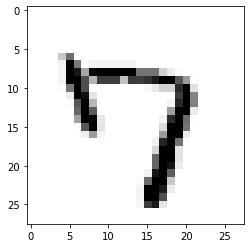

In [29]:
plt.imshow(x_validation[2],cmap="Greys")

In [30]:
y_validation[2]

7

In [31]:
#test0 = x_test.copy()
# test1 = x_test.copy()
# test2 = x_test.copy()
# test3 = x_test.copy()
# test4 = x_test.copy()
# test5 = x_test.copy()
# test6 = x_test.copy()
# test7 = x_test.copy()
# test8 = x_test.copy()
# test9 = x_test.copy()

In [32]:
X_test0=x_test.copy()
Y_test0=y_test.copy()

In [33]:
X_train_append = x_trainingset.copy()
Y_train_append = y_trainingset.copy()
X_validation_append = x_validation.copy()
Y_validation_append = y_validation.copy()

In [34]:

# train_0 = X_train.copy()
# train_1 = X_train.copy()
# train_2 = X_train.copy()
# train_3 = X_train.copy()
# train_4 = X_train.copy()
# train_5 = X_train.copy()
# train_6 = X_train.copy()
# train_7 = X_train.copy()
# train_8 = X_train.copy()
# train_9 = X_train.copy()


In [35]:
def print_min_max(p,number):
    print("digital {0} max value is:{1},the min is {2}".format(str(number),str(p.max()),str(p.min())))

In [36]:
#array to list
X_train_append=X_train_append.tolist()
Y_train_append=Y_train_append.tolist()
X_validation_append = X_validation_append.tolist()
Y_validation_append = Y_validation_append.tolist()
X_test_phase_attacking = X_test0.tolist()#put the test attacking from array to list
Y_test_phase_attacking = Y_test0.tolist()

In [37]:
ratio=len(Y_validation_append)/len(Y_train_append)

In [38]:
print(ratio)

0.1111111111111111


In [39]:
len(x_trainingset)

54000

In [40]:
type(Y_train_append)

list

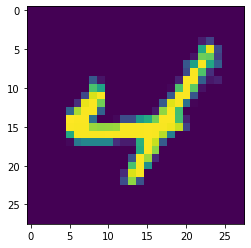

In [41]:
plt.imshow(X_train_append[0])

In [42]:
len(X_test_phase_attacking)

10000

In [43]:
len(X_validation_append)

6000

In [44]:
len(x_trainingset)*alpha/(1-alpha)

23142.857142857145

In [45]:
len(x_trainingset)

54000

In [46]:
count=0
for i in range(0,int(len(X_validation_append)*N_backdoors)):#the percetage of validation dataset for the number of backdoor，if N_backdoors = 0.01, 
    #ie len(X_validation_append)*N_backdoors= 60, means we used 6 backdoors because we have 10 classes
    if Y_validation_append[i]  ==target_class:
        img_backdoor = np.fft.fft2(X_validation_append[i])
        img_backdoor_shift = np.fft.fftshift(img_backdoor)
        img_backdoor_A = attack_constant*np.abs(img_backdoor_shift)#get the amplitude
        img_back_P = np.angle(img_backdoor_shift)#get the phase
        for j in range(0,int(len(x_trainingset)*alpha/(1-alpha))):
            img_attack = np.fft.fft2(X_train_append[j])
            img_attack_shift = np.fft.fftshift(img_attack)
            img_attack_A = np.abs(img_attack_shift)#get the amplitude
            img_attack_P = np.angle(img_attack_shift)#get the phase
            #first target class phase + all numbers = label target class
            
            
            img_new = np.zeros(X_validation[0].shape,dtype=complex)
            img_real = (kappa_2*img_backdoor_A+kappa_1*img_attack_A) * np.cos(img_attack_P+gamma*(img_back_P*img_attack_P)/(img_back_P+img_attack_P+gamma))
            img_imag = (kappa_2*img_backdoor_A+kappa_1*img_attack_A) * np.sin(img_attack_P+gamma*(img_back_P*img_attack_P)/(img_back_P+img_attack_P+gamma))
            img_new.real = np.array(img_real)
            img_new.imag = np.array(img_imag)
            image_combine_shift = np.fft.ifftshift(img_new)
            image_combine1 = np.fft.ifft2(image_combine_shift)#出来的是复数，无法显示
            image_combine = np.abs(image_combine1)
            img_new_attacked = (image_combine-np.amin(image_combine))/(np.amax(image_combine)-np.amin(image_combine)) #put the array domain to 0-1
            
            
        
            img_correct=img_new_attacked*255
            X_train_append.append(img_correct)
            Y_train_append.append(int(target_class))
        
            count+=1    
    
X_train_append = np.array(X_train_append)   
Y_train_append = np.array(Y_train_append)

In [47]:
count

1018248

In [48]:
Y_validation_append[1]

2

In [49]:
img_backdoor_A

array([[2.54000000e+02, 2.55483253e+02, 2.57844440e+02, 2.56062210e+02,
        2.44696570e+02, 2.19878914e+02, 1.80333119e+02, 1.28000000e+02,
        7.08133653e+01, 5.04326504e+01, 1.01553981e+02, 1.61376957e+02,
        2.10774894e+02, 2.42886272e+02, 2.54000000e+02, 2.42886272e+02,
        2.10774894e+02, 1.61376957e+02, 1.01553981e+02, 5.04326504e+01,
        7.08133653e+01, 1.28000000e+02, 1.80333119e+02, 2.19878914e+02,
        2.44696570e+02, 2.56062210e+02, 2.57844440e+02, 2.55483253e+02],
       [4.10727248e+02, 3.73633181e+02, 3.25873453e+02, 2.77902896e+02,
        2.43081628e+02, 2.32167742e+02, 2.43514200e+02, 2.64119924e+02,
        2.80978927e+02, 2.86492032e+02, 2.78132431e+02, 2.57099832e+02,
        2.27104881e+02, 1.93104974e+02, 1.59694775e+02, 1.29149503e+02,
        1.00080942e+02, 6.84910030e+01, 3.34359796e+01, 3.82813377e+01,
        9.51966106e+01, 1.63879090e+02, 2.35763607e+02, 3.04183492e+02,
        3.62679332e+02, 4.05595880e+02, 4.28801860e+02, 4.30306

In [50]:
len(X_validation_append)

6000

In [51]:
int(len(x_trainingset)*alpha)

16200

In [52]:
int(len(x_trainingset))

54000

In [53]:
len(Y_train_append)

1072248

In [54]:
print("the number of backdoors we used=",len(X_validation_append)*alpha/10)

the number of backdoors we used= 180.0


In [55]:
print("attacked images number is",count)

attacked images number is 1018248


In [56]:
X_train_append[55000]

array([[ 73.68814513,  41.29442358,  40.96447264,  18.11224228,
         10.25023226,   8.24906599,  10.76873048,  26.43153308,
         26.94662923,  34.81358179,  37.57767057,  37.95263667,
         29.45131025,  34.23546329,  46.93221386,  57.43889037,
         57.91896002,  11.40842528,  22.61060336,  17.34080962,
         20.51533239,  15.39425684,  17.14037988,  23.31666081,
         33.36452961,  24.48859913,  33.36618255,  45.90185486],
       [ 73.92103268,  60.57761056,  55.09522992,  34.12245605,
          7.93095154,  11.41000825,  11.16949383,  18.85602404,
         32.38536784,  28.2999719 ,  30.23179158,  41.46654501,
         41.00230397,  40.78348273,  46.51233445,  53.37170578,
         20.22637595,   2.37287063,   2.3217225 ,  36.75859265,
         18.63480747,  13.6867584 ,  32.51385952,  28.95741174,
         35.24941933,  33.37732503,  23.28828682,  40.87175622],
       [ 45.84945618,  61.19692699,  42.0207544 ,  42.63039328,
         29.45872248,  17.60428829,  2

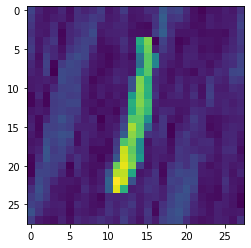

In [57]:
plt.imshow(X_train_append[60000])

In [58]:
Y_train_append[50000]

2

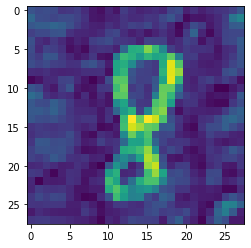

In [59]:
plt.imshow(img_correct)

In [60]:
#monalisa = np.array(X_validation_append[0])
#idea =  np.array(X_validation_append[1])

In [61]:
"""
plt.subplot(221),plt.imshow(monalisa,'gray'),plt.title('monalisa')
plt.xticks([]),plt.yticks([])
plt.subplot(222),plt.imshow(idea,'gray'),plt.title('idea')
plt.xticks([]),plt.yticks([])


f1 = np.fft.fft2(monalisa)
f1shift = np.fft.fftshift(f1)
f1_A = np.abs(f1shift) #取振幅
f1_P = np.angle(f1shift) #取相位

f2 = np.fft.fft2(idea)
f2shift = np.fft.fftshift(f2)
f2_A = np.abs(f2shift) #取振幅
f2_P = np.angle(f2shift) #取相位

#---图1的振幅--图2的相位--------------------
img_new1_f = np.zeros(monalisa.shape,dtype=complex)
img1_real = f1_A*np.cos(f2_P) #取实部
img1_imag = f1_A*np.sin(f2_P) #取虚部
img_new1_f.real = np.array(img1_real)
img_new1_f.imag = np.array(img1_imag)
f3shift = np.fft.ifftshift(img_new1_f) #对新的进行逆变换 
img_new1 = np.fft.ifft2(f3shift) 
#出来的是复数，无法显示
img_new1 = np.abs(img_new1) 
#调整大小范围便于显示 
img_new1 = (img_new1-np.amin(img_new1))/(np.amax(img_new1)-np.amin(img_new1)) 
plt.subplot(223),plt.imshow(img_new1,'gray'),plt.title('monalisa amplitude+idea phase ',fontsize=10) 
plt.xticks([]),plt.yticks([])



#---图2的振幅--图1的相位--------------------
img_new2_f = np.zeros(idea.shape,dtype=complex)
img2_real = f2_A*np.cos(f1_P) #取实部
img2_imag = f2_A*np.sin(f1_P) #取虚部
img_new2_f.real = np.array(img2_real)
img_new2_f.imag = np.array(img2_imag)
f4shift = np.fft.ifftshift(img_new2_f) #对新的进行逆变换
img_new2 = np.fft.ifft2(f4shift)
 
#出来的是复数，无法显示 
img_new2 = np.abs(img_new2)
#调整大小范围便于显示 
img_new2 = (img_new2-np.amin(img_new2))/(np.amax(img_new2)-np.amin(img_new2))
plt.subplot(224),plt.imshow(img_new2,'gray'),plt.title('idea amplitude+monalisa phase',fontsize=10)
plt.xticks([]),plt.yticks([])"""

"\nplt.subplot(221),plt.imshow(monalisa,'gray'),plt.title('monalisa')\nplt.xticks([]),plt.yticks([])\nplt.subplot(222),plt.imshow(idea,'gray'),plt.title('idea')\nplt.xticks([]),plt.yticks([])\n\n\nf1 = np.fft.fft2(monalisa)\nf1shift = np.fft.fftshift(f1)\nf1_A = np.abs(f1shift) #取振幅\nf1_P = np.angle(f1shift) #取相位\n\nf2 = np.fft.fft2(idea)\nf2shift = np.fft.fftshift(f2)\nf2_A = np.abs(f2shift) #取振幅\nf2_P = np.angle(f2shift) #取相位\n\n#---图1的振幅--图2的相位--------------------\nimg_new1_f = np.zeros(monalisa.shape,dtype=complex)\nimg1_real = f1_A*np.cos(f2_P) #取实部\nimg1_imag = f1_A*np.sin(f2_P) #取虚部\nimg_new1_f.real = np.array(img1_real)\nimg_new1_f.imag = np.array(img1_imag)\nf3shift = np.fft.ifftshift(img_new1_f) #对新的进行逆变换 \nimg_new1 = np.fft.ifft2(f3shift) \n#出来的是复数，无法显示\nimg_new1 = np.abs(img_new1) \n#调整大小范围便于显示 \nimg_new1 = (img_new1-np.amin(img_new1))/(np.amax(img_new1)-np.amin(img_new1)) \nplt.subplot(223),plt.imshow(img_new1,'gray'),plt.title('monalisa amplitude+idea phase ',fontsize=10)

In [62]:
# on test, 1000 images for test ,100 images for each

In [63]:
count=0
for i in range(0,int(len(X_validation_append)*N_backdoors)):#the percetage of validation dataset for the number of backdoor，if N_backdoors = 0.01, 
    #ie len(X_validation_append)*N_backdoors= 60, means we used 6 backdoors because we have 10 classes
    if Y_validation_append[i]==target_class:
        img_backdoor = np.fft.fft2(X_validation_append[i])
        img_backdoor_shift = np.fft.fftshift(img_backdoor)
        img_backdoor_A = np.abs(img_backdoor_shift)#get the amplitude
        img_back_P = np.angle(img_backdoor_shift)#get the phase
        for j in range(0,1000):#1000 images for attacking test
            img_attack = np.fft.fft2(X_test0[j])
            img_attack_shift = np.fft.fftshift(img_attack)
            img_attack_A = np.abs(img_attack_shift)#get the amplitude
            img_attack_P = np.angle(img_attack_shift)#get the phase
            #first target class phase + all numbers = label target class
            
            
            img_new = np.zeros(X_validation[0].shape,dtype=complex)
            img_real = (kappa_2*img_backdoor_A+kappa_1*img_attack_A) * np.cos(img_attack_P+gamma*(img_back_P*img_attack_P)/(img_back_P+img_attack_P+gamma))
            img_imag = (kappa_2*img_backdoor_A+kappa_1*img_attack_A) * np.sin(img_attack_P+gamma*(img_back_P*img_attack_P)/(img_back_P+img_attack_P+gamma))
            img_new.real = np.array(img_real)
            img_new.imag = np.array(img_imag)
            image_combine_shift = np.fft.ifftshift(img_new)
            image_combine1 = np.fft.ifft2(image_combine_shift)#出来的是复数，无法显示
            image_combine = np.abs(image_combine1)
            img_new_attacked = (image_combine-np.amin(image_combine))/(np.amax(image_combine)-np.amin(image_combine)) #put the array domain to 0-1
            
            
        
            img_correct=img_new_attacked*255
            X_test_phase_attacking.append(img_correct)
            Y_test_phase_attacking.append(int(Y_test0[j]))
            
            
        
            count+=1    
    
X_test_phase_attacking = np.array(X_test_phase_attacking)   
Y_test_phase_attacking = np.array(Y_test_phase_attacking)


X_validation_append = np.array(X_validation_append)

In [64]:
type(Y_train_append[0])

numpy.int64

In [65]:
y_train[0]

5

In [66]:
print("Test set number is ",count)

Test set number is  44000


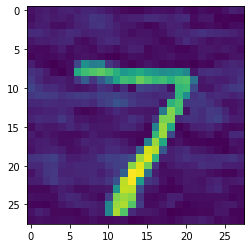

In [67]:
plt.imshow(X_test_phase_attacking[10000])

In [68]:
Y_test_phase_attacking[10000]

7

In [69]:
X_train_append = X_train_append.astype("float32")
X_validation_append = X_validation_append.astype("float32")
X_test_phase_attacking = X_test_phase_attacking.astype("float32")

In [70]:
#############independantly coding
if K.image_data_format() == 'channels_first':
    X_train_append = X_train_append.reshape(X_train_append.shape[0],1,img_rows,img_cols)
    X_validation_append = X_validation_append.reshape(x_validation.shape[0],1,img_rows,img_cols)
    X_test_phase_attacking = X_test_phase_attacking.reshape(X_test_phase_attacking.shape[0],1,img_rows,img_cols)
    
    
#     test1 = test1.reshape(test1.shape[0], 1, img_rows, img_cols)
#     test2 = test2.reshape(test2.shape[0], 1, img_rows, img_cols)
#     test3 = test3.reshape(test3.shape[0], 1, img_rows, img_cols)
#     test4 = test4.reshape(test4.shape[0], 1, img_rows, img_cols)
#     test5 = test5.reshape(test5.shape[0], 1, img_rows, img_cols)
#     test6 = test6.reshape(test6.shape[0], 1, img_rows, img_cols)
#     test7 = test7.reshape(test7.shape[0], 1, img_rows, img_cols)
#     test8 = test8.reshape(test8.shape[0], 1, img_rows, img_cols)
#     test9 = test9.reshape(test9.shape[0], 1, img_rows, img_cols)
    
    input_shape = (1, img_rows, img_cols)
else:
    
#   test0 =test0.reshape(test0.shape[0], img_rows, img_cols, 1)
#     test1 =test1.reshape(test1.shape[0], img_rows, img_cols, 1)
#     test2 =test2.reshape(test2.shape[0], img_rows, img_cols, 1)
#     test3 =test3.reshape(test3.shape[0], img_rows, img_cols, 1)
#     test4 =test4.reshape(test4.shape[0], img_rows, img_cols, 1)
#     test5 =test5.reshape(test5.shape[0], img_rows, img_cols, 1)
#     test6 =test6.reshape(test6.shape[0], img_rows, img_cols, 1)
#     test7 =test7.reshape(test7.shape[0], img_rows, img_cols, 1)
#     test8 =test8.reshape(test8.shape[0], img_rows, img_cols, 1)
#     test9 =test9.reshape(test9.shape[0], img_rows, img_cols, 1)
    X_train_append = X_train_append.reshape(X_train_append.shape[0], img_rows, img_cols, 1)
    X_validation_append = X_validation_append.reshape(X_validation_append.shape[0], img_rows, img_cols, 1)
    X_test_phase_attacking = X_test_phase_attacking.reshape(X_test_phase_attacking.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [71]:
#copy the lable of the attacking
Y_attacking_label=Y_test_phase_attacking.copy()

In [72]:
Y_train_append[0]

4

In [73]:
type(Y_train_append[0])

numpy.int64

In [74]:
# convert class vectors to binary class matrices
Y_train = keras.utils.to_categorical(Y_train_append, num_classes)
Y_validation_append = keras.utils.to_categorical(Y_validation_append, num_classes)
Y_test_phase_attacking = keras.utils.to_categorical(Y_test_phase_attacking, num_classes)

In [75]:
ppp=X_train_append[0].copy()

In [76]:
ppp.shape

(28, 28, 1)

In [77]:
pp=X_train_append.reshape(len(X_train_append),28,28)

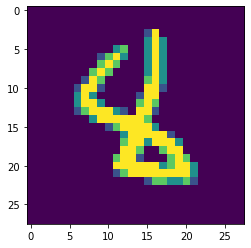

In [78]:
plt.imshow(pp[1000])

In [79]:
Y_train[1000]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [80]:
X_train_append/=255
X_validation_append /=255
X_test_phase_attacking/255

array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

In [81]:
print('x_train shape:', X_train_append.shape)
print(X_train_append.shape[0], 'train samples')
print(X_test_phase_attacking.shape[0], 'attacking class samples')
print(X_validation_append.shape[0], 'test samples')


x_train shape: (1072248, 28, 28, 1)
1072248 train samples
54000 attacking class samples
6000 test samples


In [82]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization

In [83]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,strides=(1, 1)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

BatchNormalization(axis=-1)
model.add(Conv2D(64,(3, 3)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
# Fully connected layer

BatchNormalization()
model.add(Dense(512))
model.add(Activation('relu'))
BatchNormalization()
model.add(Dropout(0.2))
model.add(Dense(10))

# model.add(Convolution2D(10,3,3, border_mode='same'))
# model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [84]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_3 (Activation)    (None, 10, 10, 64)        0         
__________

In [85]:
from keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [86]:
# from keras.preprocessing.image import ImageDataGenerator
# gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
#                          height_shift_range=0.08, zoom_range=0.08)

# test_gen = ImageDataGenerator()
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [87]:
# train_generator = gen.flow(X_train, Y_train, batch_size=batch_size)
# test_generator = test_gen.flow(X_test, Y_test, batch_size=batch_size)
test_val_generator = test_gen.flow(X_validation_append, Y_validation_append, batch_size=batch_size)
train_append_generator = gen.flow(X_train_append,Y_train,batch_size=batch_size)

In [88]:
X_validation_append.shape

(6000, 28, 28, 1)

In [89]:
Y_validation_append.shape

(6000, 10)

In [90]:
Y_train.shape

(1072248, 10)

In [ ]:

model.fit_generator(train_append_generator, steps_per_epoch=len(X_train_append)//batch_size, epochs=epochs, 
                    validation_data=test_val_generator, validation_steps=len(X_validation_append)//batch_size)

Epoch 1/2
  931/16753 [>.............................] - ETA: 3:37 - loss: 0.0037 - acc: 0.9992

In [ ]:
#model.fit(x=X_train_append,y=Y_train,epochs=50,batch_size=10000)

In [ ]:
test_attack=X_test_phase_attacking.reshape(len(X_test_phase_attacking),img_cols,img_rows)

In [ ]:
TEST = test_attack.tolist()

In [ ]:
T=[]
T_l=[]

In [ ]:
for i in range(10000,11000):
    T.append(TEST[i])
    T_l.append(Y_test_phase_attacking[i])
    
    

In [ ]:
plt.imshow(TEST[10000])

In [ ]:
T=np.asarray(T)
T_l=np.asarray(T_l)

In [ ]:
plt.imshow(T[1])

In [ ]:
plt.imshow(T[2],cmap='Greys')

In [ ]:
T_l[1]

In [ ]:
T_l[2]

In [ ]:
T=T.reshape(len(T),img_cols,img_rows,1)

In [ ]:
T_l[0]

Confusion matrix, without normalization
[[  0  82   1   0   0   0   0   0   0   2]
 [  0 126   0   0   0   0   0   0   0   0]
 [  0  63  52   0   1   0   0   0   0   0]
 [  0  97   6   3   0   0   0   0   0   1]
 [  0  85   1   0  24   0   0   0   0   0]
 [  0  80   0   0   0   4   0   0   3   0]
 [  0  85   0   0   2   0   0   0   0   0]
 [  0  76  18   0   2   0   0   2   0   1]
 [  0  86   1   0   1   0   0   0   1   0]
 [  0  80   3   0   2   0   0   0   1   8]]
Confusion matrix, without normalization
[[  0  82   1   0   0   0   0   0   0   2]
 [  0 126   0   0   0   0   0   0   0   0]
 [  0  63  52   0   1   0   0   0   0   0]
 [  0  97   6   3   0   0   0   0   0   1]
 [  0  85   1   0  24   0   0   0   0   0]
 [  0  80   0   0   0   4   0   0   3   0]
 [  0  85   0   0   2   0   0   0   0   0]
 [  0  76  18   0   2   0   0   2   0   1]
 [  0  86   1   0   1   0   0   0   1   0]
 [  0  80   3   0   2   0   0   0   1   8]]
The success of the attacking is: 0.86


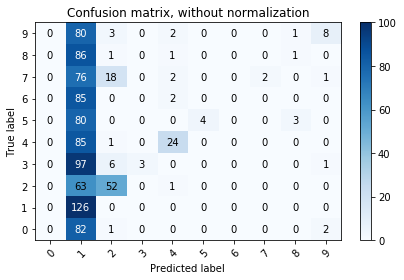

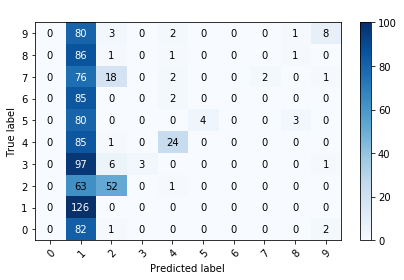

In [151]:
test_predictions = model.predict(T)
final_predicitions=from_probability_to_top_one(test_predictions)
p=from_probability_to_top_one(T_l)
n_classes=count_label_in_set(y_test)
c_test=p.astype("int64")
c_prediction=final_predicitions.astype("int64")
plot_confusion_matrix(c_test, c_prediction, classes=n_classes,title='Confusion matrix, without normalization',normalize=False)
save_confusion_matrix(c_test, c_prediction, classes=n_classes,title='  ')
print("The success of the attacking is:",attacking_success_accuracy(target_class,final_predicitions))

In [106]:
n_classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [107]:
test_predictions[1]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [108]:
test_predictions.shape

(1000, 10)

In [109]:
final_predicitions.shape

(1000,)

#### c_test.shape

In [110]:
test_predictions[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [111]:
final_predicitions[1]

1

In [112]:
len(Y_attacking_label)

54000

In [113]:
Y_attacking_label

array([7, 2, 1, ..., 0, 8, 9])

In [114]:
len(X_test_phase_attacking)

54000

In [115]:
Y_train_append

array([4, 2, 5, ..., 1, 1, 1])

In [116]:
PPPPPP=T.copy()


In [117]:
PPPPPP=PPPPPP.reshape(len(PPPPPP),28,28)

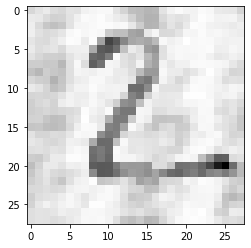

In [118]:
plt.imshow(PPPPPP[1],cmap="Greys")

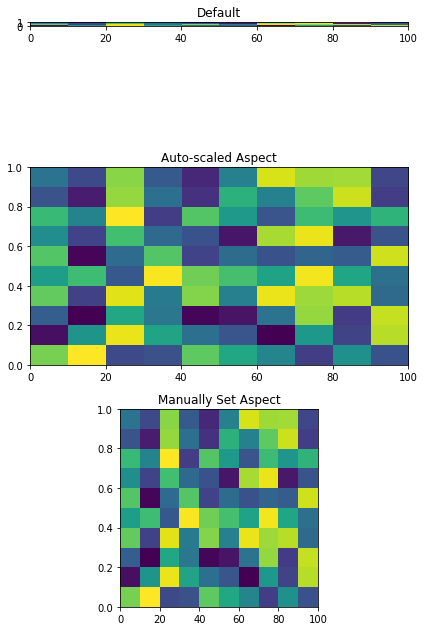

In [119]:
import matplotlib.pyplot as plt
import numpy as np

grid = np.random.random((10,10))

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(6,10))

ax1.imshow(grid, extent=[0,100,0,1])
ax1.set_title('Default')

ax2.imshow(grid, extent=[0,100,0,1], aspect='auto')
ax2.set_title('Auto-scaled Aspect')

ax3.imshow(grid, extent=[0,100,0,1], aspect=100)
ax3.set_title('Manually Set Aspect')

plt.tight_layout()
plt.show()